<a href="https://www.kaggle.com/concaption/base-model?scriptVersionId=84673217" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/concaption/PepsiCo-Lab-Potato-Quality-Control/blob/main/Potato_Starter_Code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  
import datetime
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# -- Global Variables -- 
TRAIN_PATH = '../input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Train'
TEST_PATH = '../input/pepsico-lab-potato-quality-control/Pepsico RnD Potato Lab Dataset/Test'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
TARGET_SIZE = (255, 255)
GRAY_SCALL = (3,)
INPUT_SIZE = TARGET_SIZE + GRAY_SCALL
EPOCHS = 10
CLASSES = ['Defective','Non-Defective']

In [3]:
# -- Data Normalization --
data_generator = ImageDataGenerator(samplewise_center=True, #making sure that each image has a mean of 0
                                    samplewise_std_normalization=True, #and standard deviation 1
                                    horizontal_flip=True, #Randomly flip inputs horizontally
                                    validation_split=0.3,
                                    )

In [4]:
# -- Data iterators -- 
train_data = data_generator.flow_from_directory(directory=TRAIN_PATH,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                color_mode=COLOR_MODE,
                                                subset='training',
                                                shuffle=True)         
    
validation_data = data_generator.flow_from_directory(directory=TRAIN_PATH,
                                                     target_size=TARGET_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical',
                                                     color_mode=COLOR_MODE,
                                                     subset='validation',
                                                     shuffle=True)             

test_data = data_generator.flow_from_directory(directory=TEST_PATH,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               color_mode=COLOR_MODE,
                                               shuffle=True)

Found 539 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


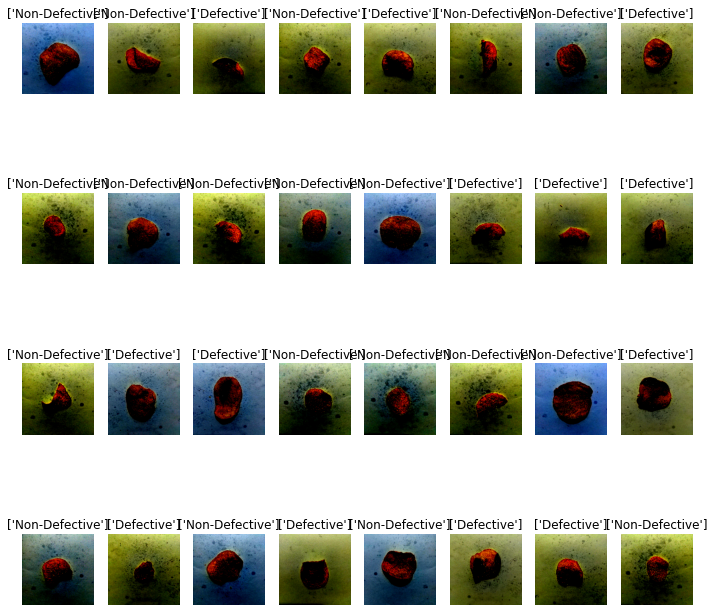

In [5]:
# -- plot random batch -- 
images, labels = train_data.next()
classes = np.asarray(CLASSES)

_, axs = plt.subplots(4, 8, figsize=(12,12))
axs = axs.flatten()
for img, label, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.axis('off')
    label = label.astype(int)
    ax.set_title(classes[label == 1])
plt.show()

In [6]:
def my_model():
  vgg19_model = VGG19(weights='imagenet',include_top=False,input_shape=INPUT_SIZE)
  vgg19_model.trainable = False
  flatten =Flatten()(vgg19_model.layers[-1].output)
  fc1 = Dense(units=4096, activation ='relu')(flatten)
  dropout = Dropout(0.2)(fc1)
  fc2 = Dense(units=1024,activation='relu')(dropout)
  output = Dense(2, activation='softmax')(fc2)
  model = Model(inputs = vgg19_model.input, outputs=output)
  model.summary()
  return model

In [7]:
model = my_model()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
______________________________________________________________

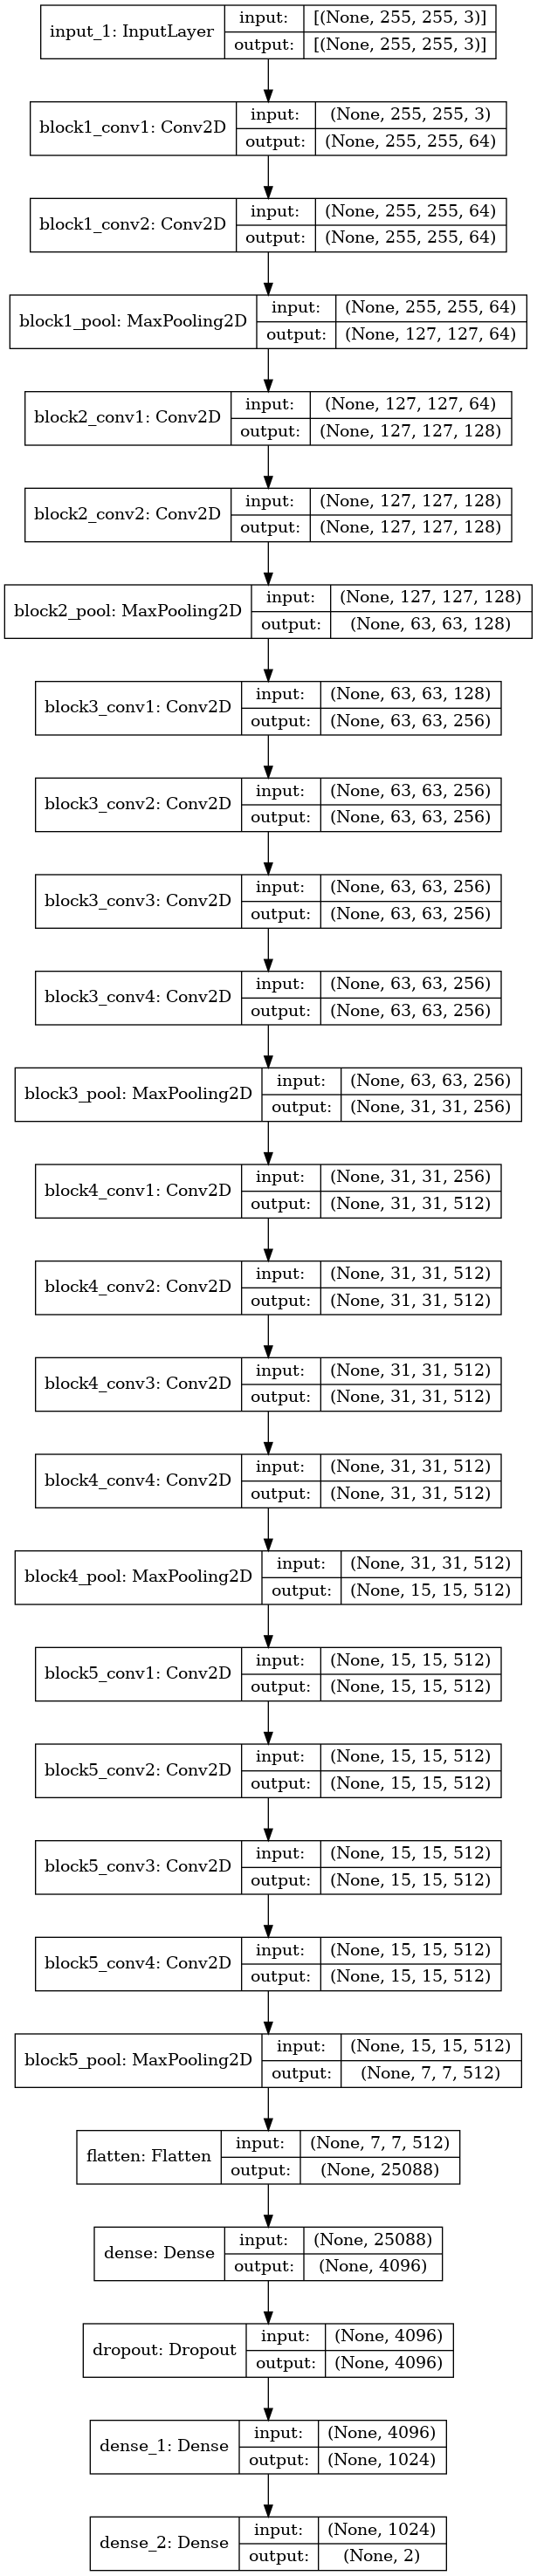

In [8]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='T', expand_nested=False, dpi=96
)

In [9]:
# -- Define optimizer and loss --
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = tf.keras.losses.CategoricalCrossentropy()

In [10]:
# -- Compile model --
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [11]:
 # -- Callbacks --
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', 
                                                    monitor='accuracy', verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False, 
                                                    mode='auto', 
                                                    save_freq='epoch')
    
earlystoping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                    min_delta=0, 
                                                    patience=5,  #Number of epochs with no improvement after which training will be stopped.
                                                    verbose=1, 
                                                    mode='auto')
    
log_dir = './logs/fit/' + datetime.datetime.now().strftime('%m.%d.%Y--%H-%M-%S')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                 histogram_freq=1, 
                                                 write_graph=True,
                                                 write_images=False, 
                                                 update_freq='epoch')

2022-01-07 15:58:24.689836: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-07 15:58:24.689936: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-07 15:58:24.691042: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [13]:
# -- Train model --
history = model.fit(x=train_data, 
                        epochs=EPOCHS, 
                        steps_per_epoch=len(train_data), 
                        verbose=1, 
                        validation_data=validation_data, 
                        validation_steps=1)
    
# -- Save model -- 
model.save('my_model.h5')

Epoch 1/10
17/17 [==============================] - 271s 16s/step - loss: 0.0772 - accuracy: 0.9722 - val_loss: 0.0406 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 267s 16s/step - loss: 0.0261 - accuracy: 0.9907 - val_loss: 0.2235 - val_accuracy: 0.9375
Epoch 3/10
17/17 [==============================] - 266s 15s/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.1387 - val_accuracy: 0.9375
Epoch 4/10
17/17 [==============================] - 266s 15s/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.1173 - val_accuracy: 0.9688
Epoch 5/10
17/17 [==============================] - 266s 15s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3615 - val_accuracy: 0.8438
Epoch 6/10
17/17 [==============================] - 266s 15s/step - loss: 0.0024 - accuracy: 0.9981 - val_loss: 0.0686 - val_accuracy: 0.9688
Epoch 7/10
17/17 [==============================] - 268s 16s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 

In [15]:
def learning_curves(history):
    '''plot learning curves'''
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss - Cross Entropy')
    plt.xlabel('epoch')
    plt.ylim([0,1.6])
    plt.title('Training and Validation Loss')
    
    plt.show()

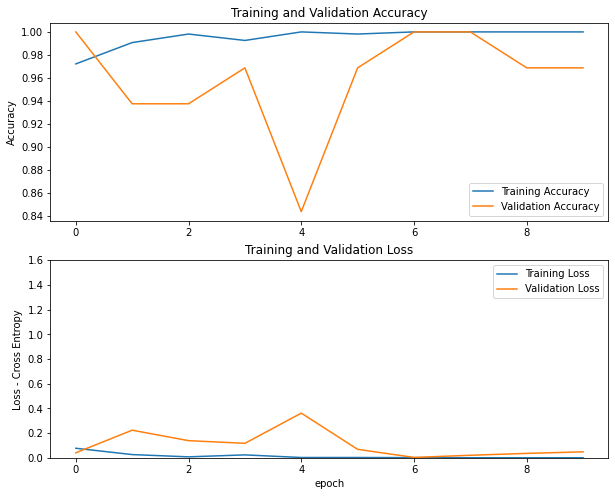

In [16]:
# -- Plot learning curves -- 
learning_curves(history)

In [17]:
# -- Evaluate the model on the test data -- 
loss, accuracy = model.evaluate(x=test_data)
print("test loss: ", loss, ", test acc: " , 100*accuracy, "%")

6/6 [==============================] - 90s 14s/step - loss: 0.4790 - accuracy: 0.8802
test loss:  0.4789600372314453 , test acc:  88.02083134651184 %


In [18]:
def defective_or_not(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(255,255,3))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    model = tf.keras.models.load_model('my_model.h5')
    output = model.predict(img)
    print(classes[output[0]==1])

In [20]:
# defective_or_not(image.png)